In [468]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing and metrics 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Exploratory Data Analysis (EDA)

We download the following dataset on bicyclist injuries from Kaggle, collected from the state of North Carolina.

In [469]:
bicycle = pd.read_csv('data/NCDOT_BikePedCrash.csv')

## Data Cleaning 

In [470]:
all_columns = bicycle.columns

all_columns

Index(['X', 'Y', 'OBJECTID', 'AmbulanceR', 'BikeAge', 'BikeAgeGrp',
       'BikeAlcDrg', 'BikeAlcFlg', 'BikeDir', 'BikeInjury', 'BikePos',
       'BikeRace', 'BikeSex', 'City', 'County', 'CrashAlcoh', 'CrashDay',
       'CrashGrp', 'CrashHour', 'CrashLoc', 'CrashMonth', 'CrashSevr',
       'CrashType', 'CrashYear', 'Developmen', 'DrvrAge', 'DrvrAgeGrp',
       'DrvrAlcDrg', 'DrvrAlcFlg', 'DrvrInjury', 'DrvrRace', 'DrvrSex',
       'DrvrVehTyp', 'HitRun', 'Latitude', 'LightCond', 'Locality',
       'Longitude', 'NumBicsAin', 'NumBicsBin', 'NumBicsCin', 'NumBicsKil',
       'NumBicsNoi', 'NumBicsTot', 'NumBicsUin', 'NumLanes', 'NumUnits',
       'RdCharacte', 'RdClass', 'RdConditio', 'RdConfig', 'RdDefects',
       'RdFeature', 'RdSurface', 'Region', 'RuralUrban', 'SpeedLimit',
       'TraffCntrl', 'Weather', 'Workzone'],
      dtype='object')

There are many columns that are not relevant to our goals of determining which features leads to likely accidents. We drop these features to simplify our dataset.

In [471]:
## Keep the following columns, and drop the rest

keep_columns = ['AmbulanceR', 'BikeAgeGrp', 'BikeDir', 'BikeInjury', 'BikePos', 'BikeRace',
                'BikeSex', 'CrashDay', 'CrashHour', 'CrashMonth', 'CrashLoc', 'DrvrVehTyp',
                'LightCond', 'Locality', 'NumLanes', 'RdCharacte', 'RdClass',
                'RdConditio', 'RdConfig', 'RdFeature', 'RdSurface', 'Region',
                'SpeedLimit', 'TraffCntrl', 'Weather', 'Workzone']

drop_columns_set = set(all_columns) - set(keep_columns)

drop_columns = sorted(drop_columns_set)

In [472]:
# Our new dataframe with only the relevant columns 
# 'inplace = True' changes the dataframe directly

bicycle.drop(columns = drop_columns, inplace = True)

In [473]:
bicycle.shape
bicycle.values.shape

(11266, 26)

In [474]:
## prints out all columns along with the frequency of each of their observations

for col in bicycle.columns:
    print(bicycle[col].value_counts())
    print()

AmbulanceR
Yes    7656
No     3610
Name: count, dtype: int64

BikeAgeGrp
50-59      1599
40-49      1588
20-24      1392
30-39      1327
11-15      1320
16-19      1161
25-29       955
6-10        736
60-69       697
Unknown     196
70+         185
0-5         110
Name: count, dtype: int64

BikeDir
With Traffic      6780
Facing Traffic    2731
Not Applicable    1315
Unknown            440
Name: count, dtype: int64

BikeInjury
B: Suspected Minor Injury      4660
C: Possible Injury             4338
O: No Injury                   1102
A: Suspected Serious Injury     577
Unknown Injury                  339
K: Killed                       250
Name: count, dtype: int64

BikePos
Travel Lane                                 7015
Sidewalk / Crosswalk / Driveway Crossing    2013
Bike Lane / Paved Shoulder                   675
Non-Roadway                                  612
Unknown                                      501
Driveway / Alley                             280
Other                    

In [475]:
# Drop rows containing unknown values from BikeInjury
bicycle.drop(bicycle[bicycle.BikeInjury == 'Unknown Injury'].index, inplace=True)

# Drop rows containing unknown values from BikeRace
bicycle.drop(bicycle[bicycle.BikeRace == 'Unknown/Missing'].index, inplace=True)

# Drop rows containing unknown values from CrashLoc
bicycle.drop(bicycle[bicycle.CrashLoc == 'Unknown Location'].index, inplace=True)

# Drop '.' from RdClass
bicycle.drop(bicycle[bicycle.RdClass == '.'].index, inplace=True)

# Drop remaining rows that contain unkown values
for col in bicycle.columns:
    bicycle.drop(bicycle[bicycle[col] == 'Unknown'].index, inplace=True)


In [476]:
bicycle.shape

(8413, 26)

### Label Encoding

In [477]:
# Label encode the 'CrashMonth' column with month numbers 
# One-hot encoding would introduce too many additional columns

month_mapping = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }

bicycle['CrashMonth'] = bicycle['CrashMonth'].map(month_mapping)

In [478]:
# Label encode the 'CrashDay' column too

weekday_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

bicycle['CrashDay'] = bicycle['CrashDay'].map(weekday_mapping)

### Combining Categories of Each Feature

In [ ]:
# Add new column 'Severity' (combine the injury types in BikeInjury)
# Is another target variable y in addition to AmbulanceR

bicycle['Severity'] = 'Not_Severe'

bicycle.loc[(bicycle['BikeInjury'] =='K: Killed') | (bicycle['BikeInjury'] =='A: Suspected Serious Injury'), 'Severity'] = 'Severe'

bicycle['Severity'].value_counts(normalize=True)

Severity
Not_Severe    0.917746
Severe        0.082254
Name: proportion, dtype: float64

In [480]:
## Simplify Weather column into 2 categories: Clear and Not Clear

bicycle['Weather'] = bicycle['Weather'].astype('string')

bicycle.loc[bicycle['Weather'].loc[bicycle['Weather'] != 'Clear'].index, 'Weather'] = 'Not Clear'

In [481]:
## Simplify 'DrvrVehTyp' column into 2 categories: 

bicycle['DrvrVehTyp'] = bicycle['DrvrVehTyp'].astype('string')

bicycle.loc[bicycle['DrvrVehTyp'].loc[bicycle['DrvrVehTyp'] != 'Passenger Car'].index, 'DrvrVehTyp'] = 'None Passenger Car'

In [482]:
## Simplify 'RdConditio' column into 2 

bicycle['RdConditio'] = bicycle['RdConditio'].astype('string')

bicycle.loc[bicycle['RdConditio'].loc[bicycle['RdConditio'] != 'Dry'].index, 'RdConditio'] = 'Not Dry'

In [483]:
## Simplify 'RdSurface' column into 2 

bicycle['RdSurface'] = bicycle['RdSurface'].astype('string')

bicycle.loc[bicycle['RdSurface'].loc[bicycle['RdSurface'] != 'Smooth Asphalt'].index, 'RdSurface'] = 'Not Smooth Asphalt'

In [484]:
## Simplify 'RdClass' column into 2 

bicycle['RdClass'] = bicycle['RdClass'].astype('string')

bicycle.loc[bicycle['RdClass'].loc[bicycle['RdClass'] != 'Local Street'].index, 'RdClass'] = 'Not Local Street'

In [485]:
## Simplify 'RdCharacte' column into 2 

bicycle['RdCharacte'] = bicycle['RdCharacte'].astype('string')

bicycle.loc[bicycle['RdCharacte'].loc[bicycle['RdCharacte'] != 'Straight - Level'].index, 'RdCharacte'] = 'Not Straight - Level'

In [486]:
## Simplify 'RdFeature' column into 2 

bicycle['RdFeature'] = bicycle['RdFeature'].astype('string')

bicycle.loc[bicycle['RdFeature'].loc[bicycle['RdFeature'] != 'No Special Feature'].index, 'RdFeature'] = 'Special Feature'

In [487]:
## Simplify 'NumLanes' column into 2 

bicycle['NumLanes'] = bicycle['NumLanes'].astype('string')

bicycle.loc[bicycle['NumLanes'].loc[bicycle['NumLanes'] != '2 lanes'].index, 'NumLanes'] = 'No 2 lanes'

In [488]:
## Simplify 'TraffCntrl' column into 2 

bicycle['TraffCntrl'] = bicycle['TraffCntrl'].astype('string')

bicycle.loc[bicycle['TraffCntrl'].loc[bicycle['TraffCntrl'] != 'No Control Present'].index, 'TraffCntrl'] = 'Control Present'

In [489]:
## BikePos

bicycle['BikePos'] = bicycle['BikePos'].astype('string')

bicycle.loc[bicycle['BikePos'].loc[bicycle['BikePos'] != 'Travel Lane'].index, 'BikePos'] = 'Not Travel Lane'

In [490]:
## LightCond

bicycle['LightCond'] = bicycle['LightCond'].astype('string')

bicycle.loc[bicycle['LightCond'].loc[bicycle['LightCond'] != 'Daylight'].index, 'LightCond'] = 'Dark'

In [491]:
# RdConfig

bicycle['RdConfig'] = bicycle['RdConfig'].astype('string')

bicycle.loc[bicycle['RdConfig'] == 'Two-Way, Not Divided', 'RdConfig'] = 'Not Divided'
bicycle.loc[bicycle['RdConfig'] == 'One-Way, Not Divided', 'RdConfig'] = 'Not Divided'
bicycle.loc[bicycle['RdConfig'] == 'Two-Way, Divided, Unprotected Median', 'RdConfig'] = 'Divided'
bicycle.loc[bicycle['RdConfig'] == 'Two-Way, Divided, Positive Median Barrier', 'RdConfig'] = 'Divided'

In [492]:
# BikeAgeGrp

bicycle['BikeAgeGrp'] = bicycle['BikeAgeGrp'].astype('string')

bicycle.loc[bicycle['BikeAgeGrp'] == '0-5', 'BikeAgeGrp'] = '24 and below'
bicycle.loc[bicycle['BikeAgeGrp'] == '6-10', 'BikeAgeGrp'] = '24 and below'
bicycle.loc[bicycle['BikeAgeGrp'] == '11-15', 'BikeAgeGrp'] = '24 and below'
bicycle.loc[bicycle['BikeAgeGrp'] == '16-19', 'BikeAgeGrp'] = '24 and below'
bicycle.loc[bicycle['BikeAgeGrp'] == '20-24', 'BikeAgeGrp'] = '24 and below'

bicycle.loc[bicycle['BikeAgeGrp'] == '25-29', 'BikeAgeGrp'] = '25-49'
bicycle.loc[bicycle['BikeAgeGrp'] == '30-39', 'BikeAgeGrp'] = '25-49'
bicycle.loc[bicycle['BikeAgeGrp'] == '40-49', 'BikeAgeGrp'] = '25-49'

bicycle.loc[bicycle['BikeAgeGrp'] == '50-59', 'BikeAgeGrp'] = '50 and above'
bicycle.loc[bicycle['BikeAgeGrp'] == '60-69', 'BikeAgeGrp'] = '50 and above'
bicycle.loc[bicycle['BikeAgeGrp'] == '70+', 'BikeAgeGrp'] = '50 and above'

In [493]:
# SpeedLimit

bicycle['SpeedLimit'] = bicycle['SpeedLimit'].astype('string')

bicycle.loc[bicycle['SpeedLimit'] == '5 - 15 MPH', 'SpeedLimit'] = 'At most 35 MPH'
bicycle.loc[bicycle['SpeedLimit'] == '20 - 25  MPH', 'SpeedLimit'] = 'At most 35 MPH'
bicycle.loc[bicycle['SpeedLimit'] == '30 - 35  MPH', 'SpeedLimit'] = 'At most 35 MPH'

bicycle.loc[bicycle['SpeedLimit'] == '40 - 45  MPH', 'SpeedLimit'] = 'Above 35 MPH'
bicycle.loc[bicycle['SpeedLimit'] == '50 - 55  MPH', 'SpeedLimit'] = 'Above 35 MPH'
bicycle.loc[bicycle['SpeedLimit'] == '60 - 75 MPH', 'SpeedLimit'] = 'Above 35 MPH'

In [494]:
# # New column 'Seasons'

# bicycle['CrashMonth'] = bicycle['CrashMonth'].astype('string')

# bicycle.loc[(bicycle['CrashMonth'] == '3') | (bicycle['CrashMonth'] == '4') | (bicycle['CrashMonth'] == '5'), 'Seasons'] = 'Spring'
# bicycle.loc[(bicycle['CrashMonth'] == '6') | (bicycle['CrashMonth'] == '7') | (bicycle['CrashMonth'] == '8'), 'Seasons'] = 'Summer'
# bicycle.loc[(bicycle['CrashMonth'] == '9') | (bicycle['CrashMonth'] == '10') | (bicycle['CrashMonth'] == '11'), 'Seasons'] = 'Fall'
# bicycle.loc[(bicycle['CrashMonth'] == '12') | (bicycle['CrashMonth'] == '1') | (bicycle['CrashMonth'] == '2'), 'Seasons'] = 'Winter'

## Save Edited Dataframe to CSV File

In [495]:
## Saving our edited dataframe

bicycle.to_csv('Bike_Crash_edited', index=False)

## Graphs / Data Visualizations

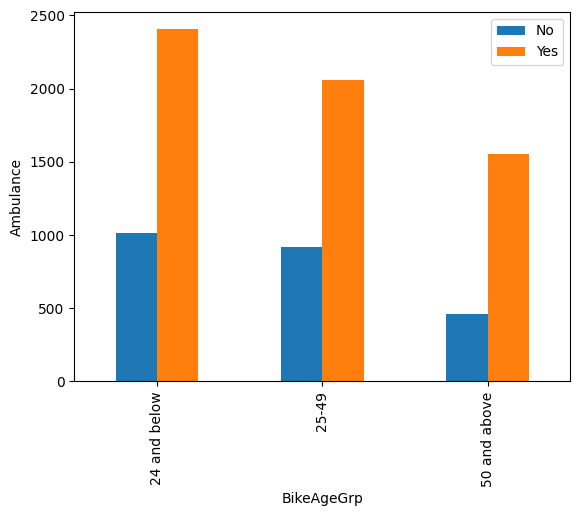

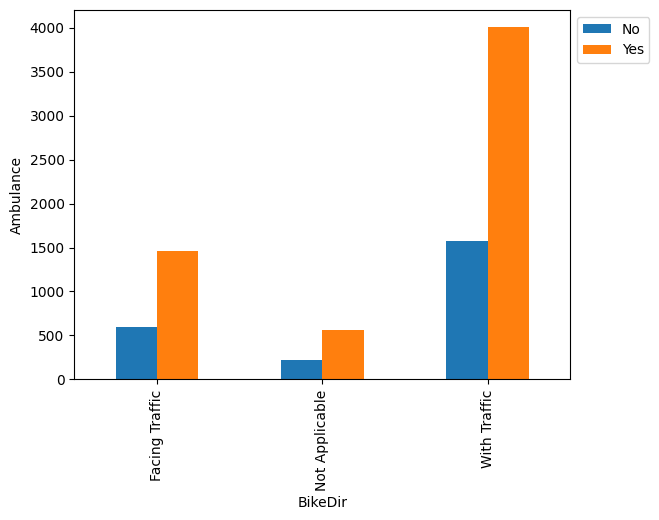

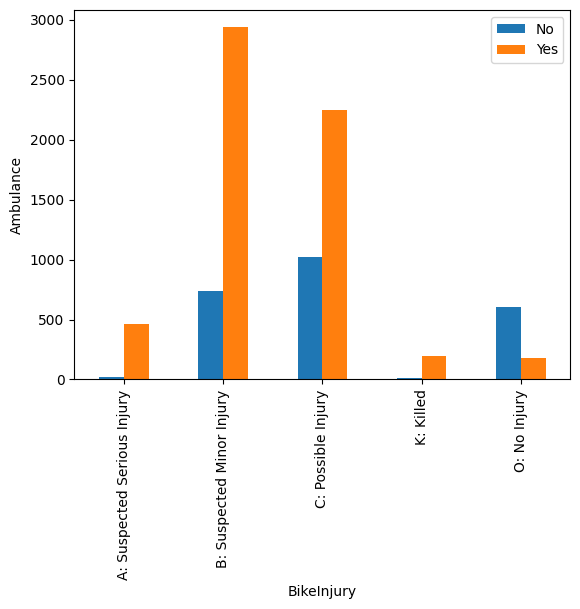

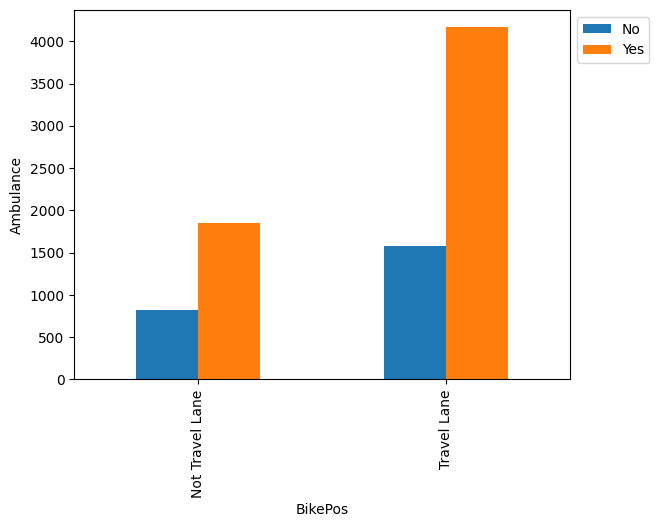

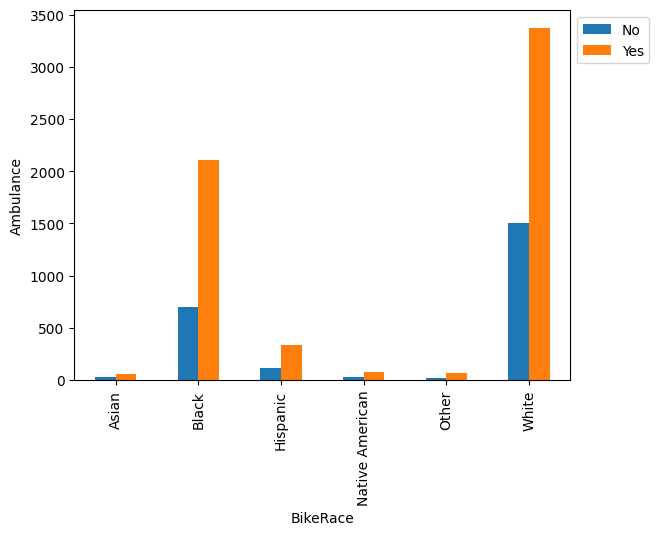

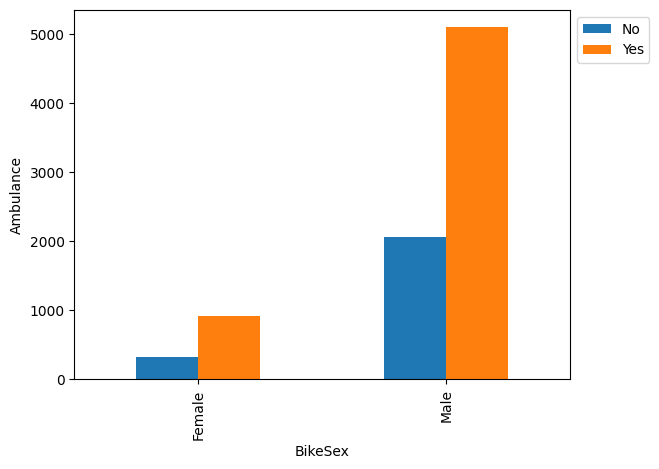

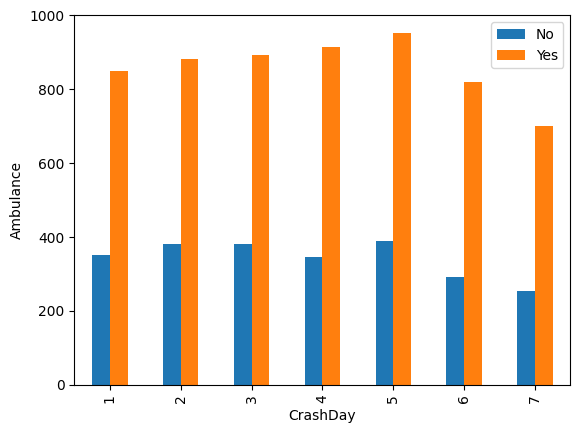

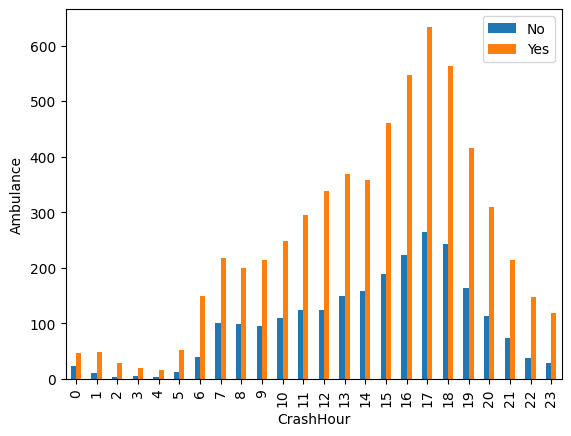

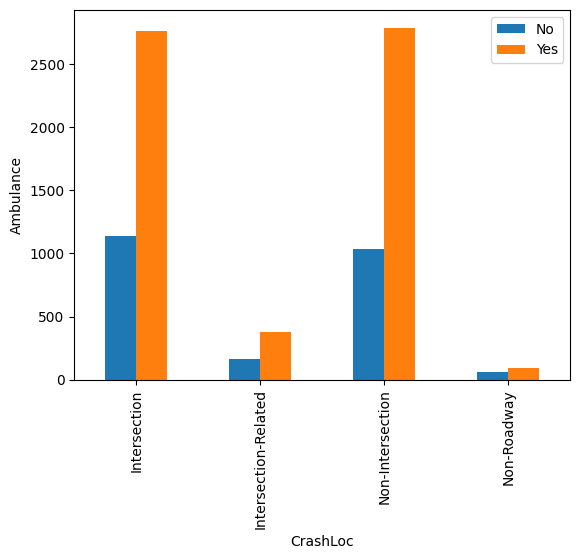

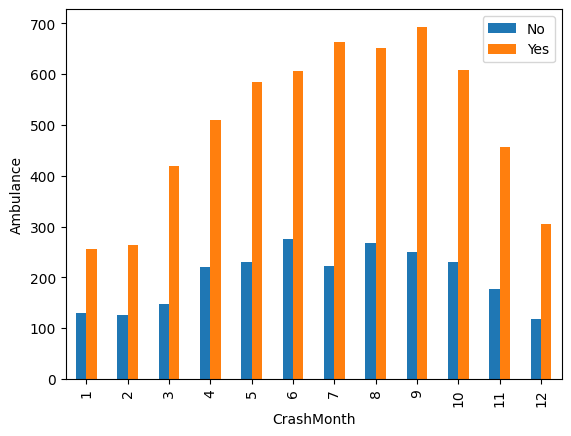

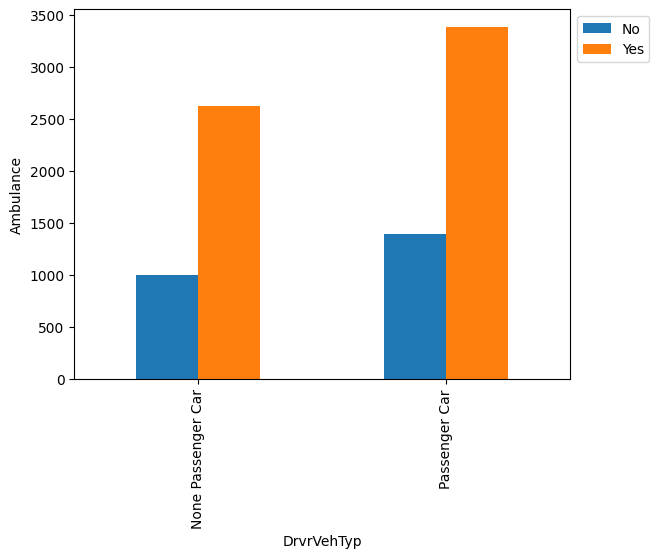

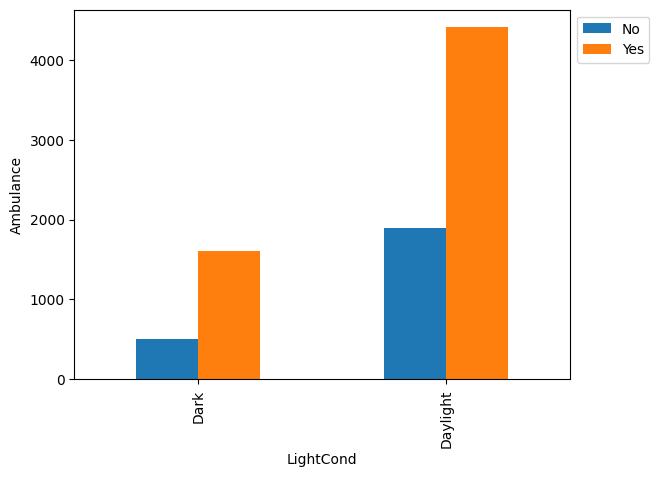

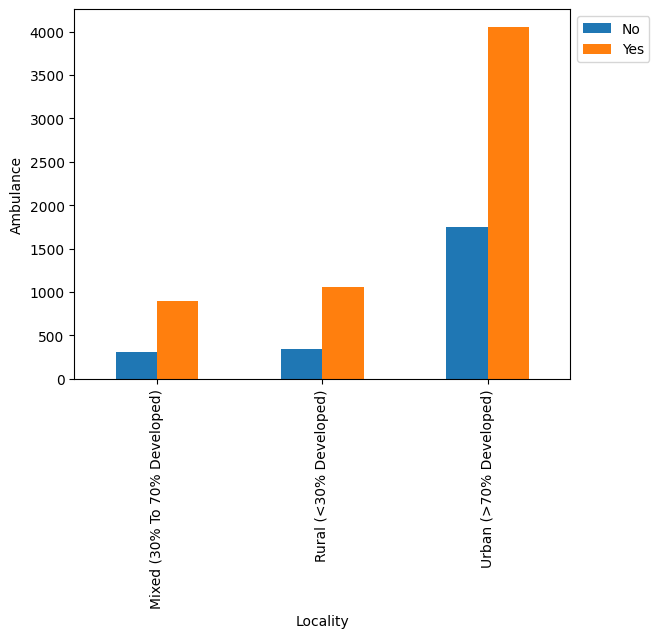

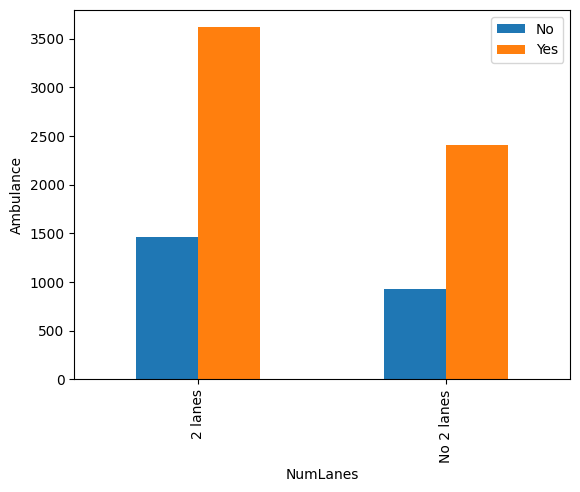

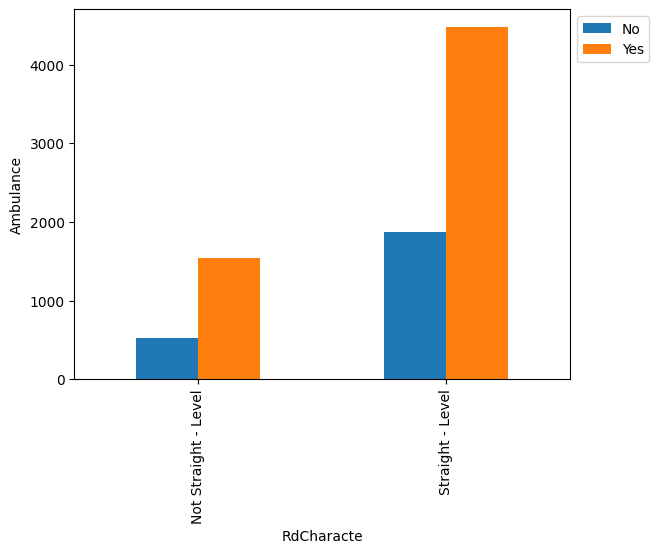

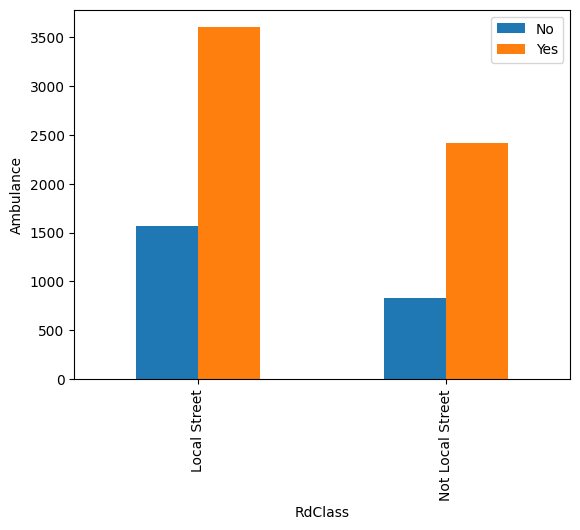

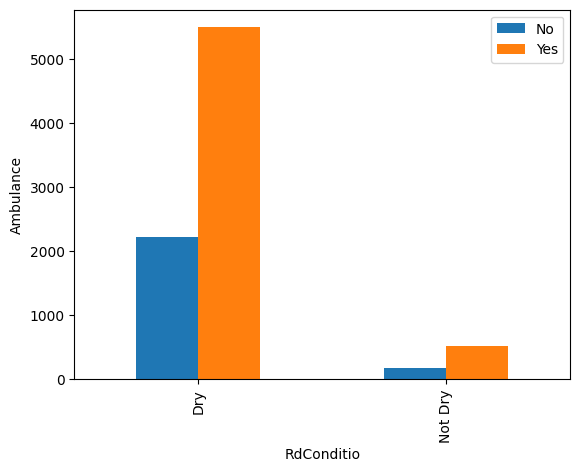

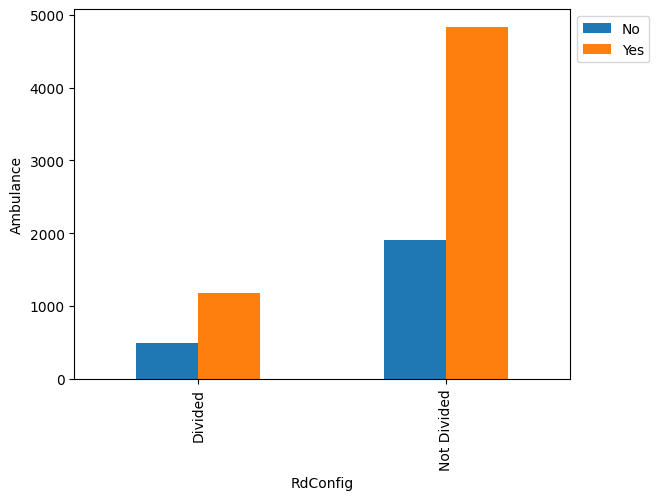

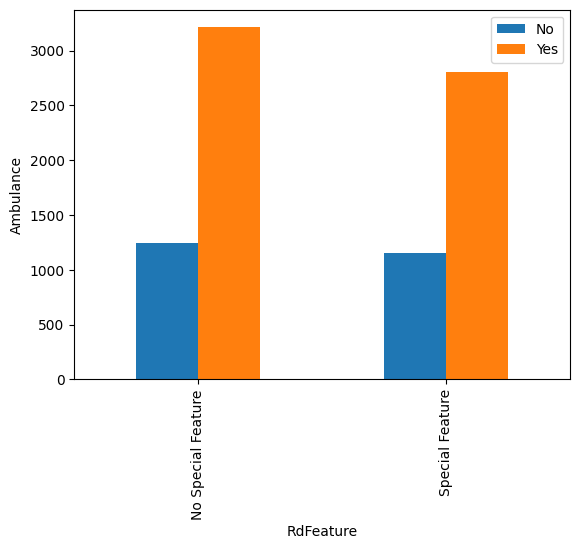

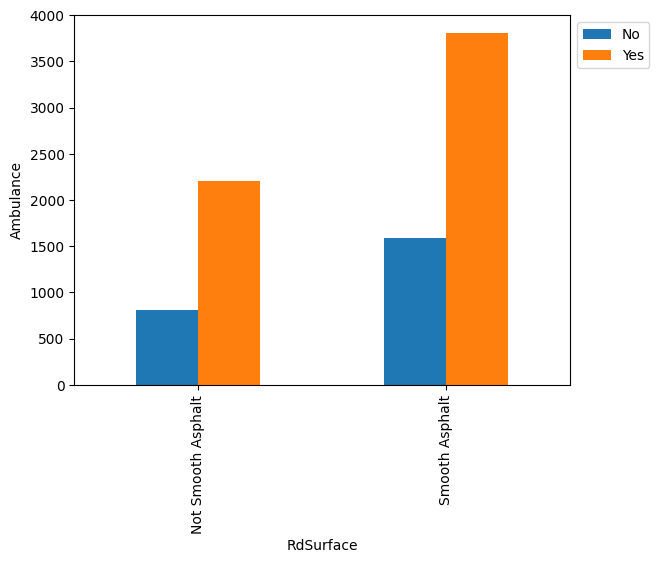

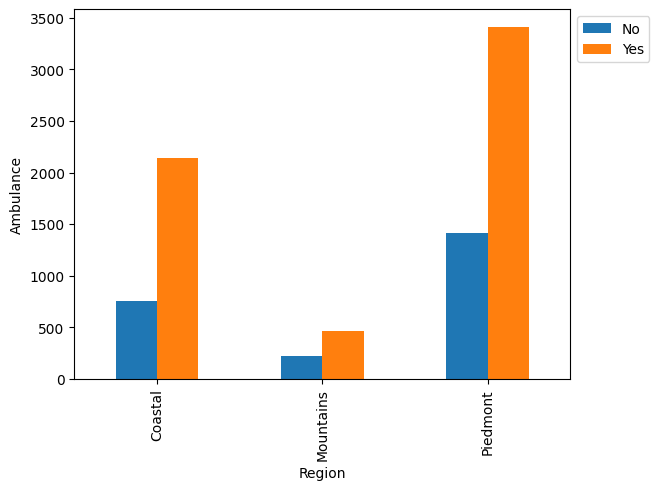

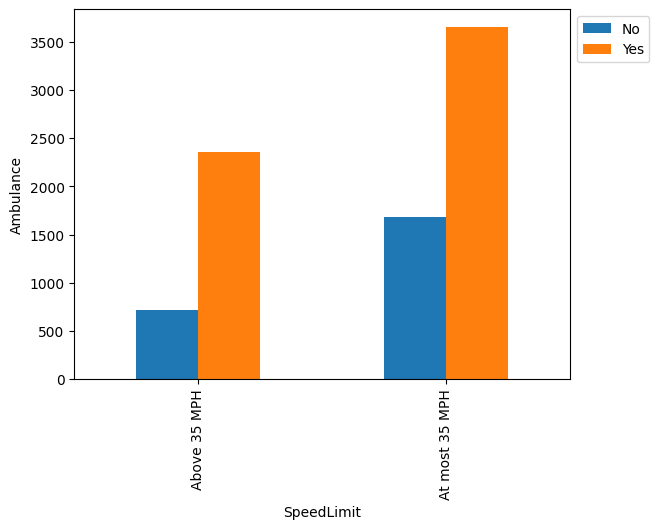

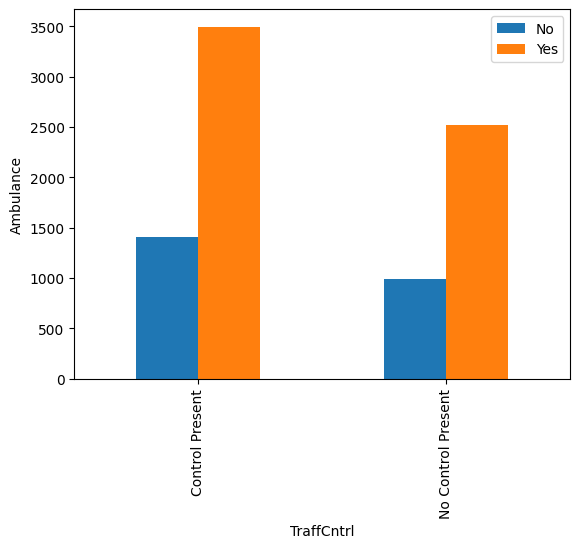

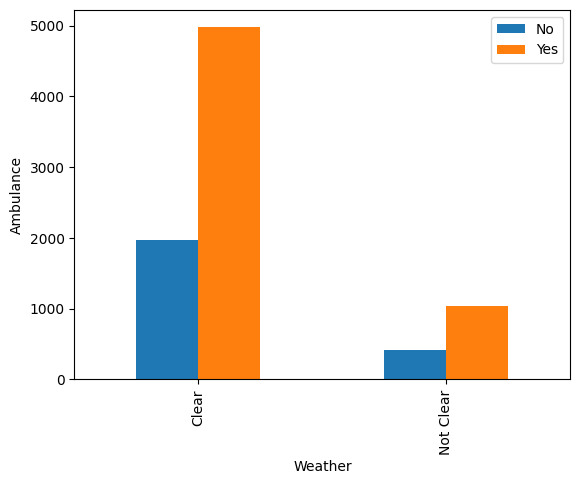

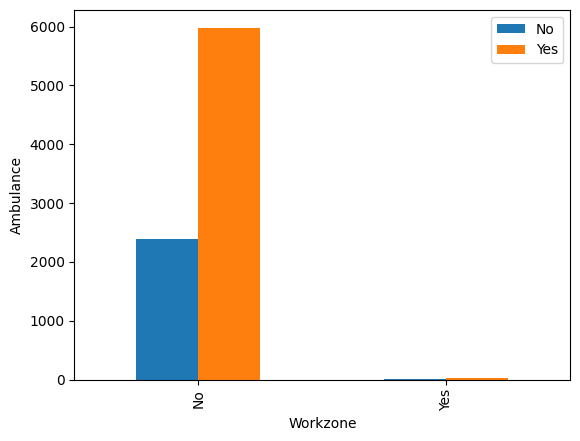

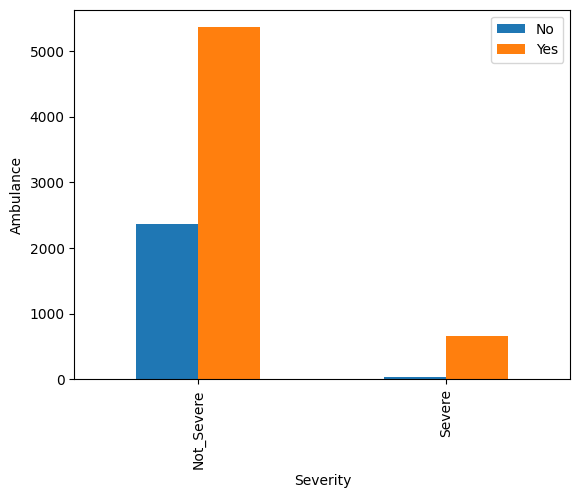

In [496]:
## Bar graphs comparing 'AmbulanceR' to all other freatures 

column_names = bicycle.columns.drop(['AmbulanceR'])

for col in column_names:
    pd.crosstab(bicycle[col], bicycle['AmbulanceR']).plot(kind='bar', stacked=False)
    plt.xlabel(col)
    plt.ylabel('Ambulance')
    plt.legend(bbox_to_anchor=(1, 1))

    plt.show()

# The Models

We choose machine learning models that work best for datasets which consists of all categorical variables (Note: one must still encode the features before fitting the models). We first focus on a target variable with two categories, the 'AmbulanceR' column consisting of 'yes' or 'no'. This is a simple indicator on whether a bike accident was serious or not.

In [497]:
bicycle['CrashMonth']=bicycle['CrashMonth'].astype(int)

In [498]:
## The selected features (X)
features = ['BikeSex', 'CrashMonth', 'NumLanes', 'RdCharacte', 'RdConditio', 'RdFeature', 'Region', 'TraffCntrl', 'Weather']

## Drop first columns of each one-hot encoded feature to avoid overfitting
X = pd.get_dummies(bicycle[features], 
                   dtype=int, 
                   drop_first=True)

## Target (y) is binary
y = bicycle['AmbulanceR']

## Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)


In [499]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

lr.fit(X_train, y_train)

print(classification_report(y_test, lr.predict(X_test)))
print()
print(confusion_matrix(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

          No       0.31      0.53      0.39       485
         Yes       0.74      0.53      0.61      1198

    accuracy                           0.53      1683
   macro avg       0.52      0.53      0.50      1683
weighted avg       0.61      0.53      0.55      1683


[[258 227]
 [567 631]]


# Severity of Bike Injuries

In [500]:
## The selected features (X)
features = ['BikeSex', 'NumLanes', 'RdCharacte', 'RdConditio', 'RdFeature', 'Region', 'TraffCntrl', 'Weather']

## Drop first columns of each one-hot encoded feature to avoid overfitting
X = pd.get_dummies(bicycle[features], 
                   dtype=int, 
                   drop_first=True)

## Target (y) is binary
y = bicycle['Severity']

## Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [501]:
## (Binary) Logistic Regression model

lg = LogisticRegression(penalty=None, max_iter=1000, class_weight='balanced')

lg.fit(X_train, y_train)

lg_pred = lg.predict(X_test)

print(classification_report(y_test, lg_pred, zero_division=0.0,
                            target_names = ['Not_Severe = 0', 'Severe = 1']))

print(confusion_matrix(y_test, lg_pred))

                precision    recall  f1-score   support

Not_Severe = 0       0.94      0.53      0.68      1537
    Severe = 1       0.11      0.62      0.19       146

      accuracy                           0.54      1683
     macro avg       0.52      0.57      0.43      1683
  weighted avg       0.86      0.54      0.64      1683

[[818 719]
 [ 56  90]]
